# Results !

In [3]:
%reset -f
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from disaggregator import data

Import the data from the optimization notebook

In [13]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

In [14]:
with open("project_data/out/lengths.json", 'r') as file:
    pipesLengths = json.load(file)

In [15]:
plantsCosts          = []
plantsServings       = []
plantsLocations      = []
plantsSpecifications = []

with open("project_data/out/optimalPlaces_b20_110_minDistance.json", 'r') as file:
    optimalPlaces = json.load(file)
        
plantsCosts          = optimalPlaces["costs"]
plantsServings       = optimalPlaces["servings"]
plantsLocations      = optimalPlaces["locations"]
plantsSpecifications = optimalPlaces["specifications"]

Prepare the x-axis by keeping the only the values where a solution has been found

In [16]:
X = [len(i) for i in plantsLocations if len(i) > 0]

## CAPEX evolution

First, we will analyze the CAPEX. In the following graph we can see the total CAPEX, as well as the highest and lowest CAPEX out of all the n plants.

Text(0, 0.5, 'Total cost of the installation of all the plants [m$]')

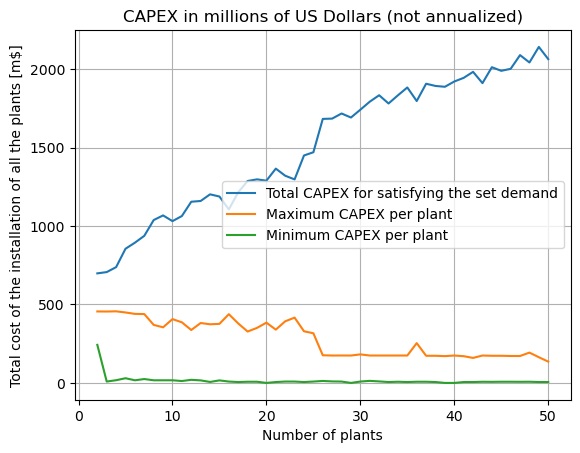

In [17]:
plt.plot(X, [sum(a) / 1e6 for a in plantsCosts if len(a) > 0], label = "Total CAPEX for satisfying the set demand")
plt.plot(X, [max(a) / 1e6 for a in plantsCosts if len(a) > 0], label = "Maximum CAPEX per plant")
plt.plot(X, [min(a) / 1e6 for a in plantsCosts if len(a) > 0], label = "Minimum CAPEX per plant")

plt.grid()
plt.legend()

plt.title("CAPEX in millions of US Dollars (not annualized)")
plt.xlabel("Number of plants")
plt.ylabel("Total cost of the installation of all the plants [m$]")

## Number of districts served

In here, we can see the minimum and maximum number of districts the plants serve.

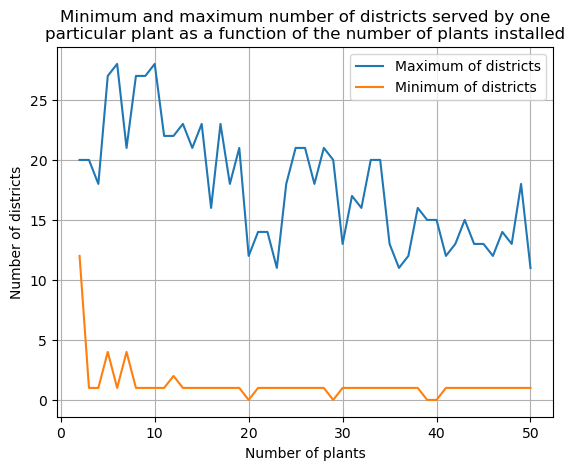

In [18]:
Ymin = []
Ymax = []

for i in plantsServings:
    if (len(i) == 0): continue
    
    Ymin.append(min([len(a) for a in i]))
    Ymax.append(max([len(a) for a in i]))

plt.plot(X, Ymax, label = "Maximum of districts")
plt.plot(X, Ymin, label = "Minimum of districts")

plt.xlabel("Number of plants")
plt.ylabel("Number of districts")
plt.title("Minimum and maximum number of districts served by one\nparticular plant as a function of the number of plants installed")

plt.legend()
plt.grid()

## Distance from plants

In this following graph we can see the mean, standard deviation, minimum and maximum distance for each of the clusters.

In [20]:
def getDistancePath(path): # Returns the length of a path by adding the length between all the points inside of a path
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

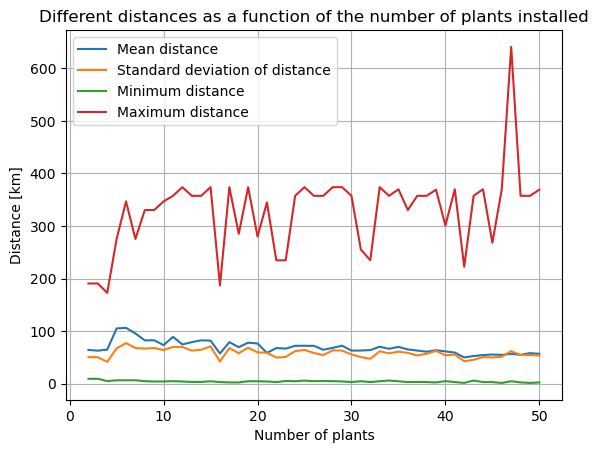

In [21]:
meanDistance = []
stdDistance = []

minDistance = []
maxDistance = []

for i, cluster in enumerate(plantsServings):
    if (len(cluster) == 0): continue
    
    mn  = 0
    avg = 0
    
    lengths = []
    
    for j, servs in enumerate(cluster):
        for serv in servs:
            lengths.append(getDistancePath(Connections[plantsLocations[i][j]][serv]))
    
    lengths = np.array(lengths)
    
    meanDistance.append(np.mean(lengths))
    stdDistance.append(np.std(lengths))

    minDistance.append(min(lengths))
    maxDistance.append(max(lengths))
    
plt.plot(X, meanDistance, label = "Mean distance")
plt.plot(X, stdDistance, label = "Standard deviation of distance")

plt.plot(X, minDistance, label = "Minimum distance")
plt.plot(X, maxDistance, label = "Maximum distance")

plt.xlabel("Number of plants")
plt.ylabel("Distance [km]")
plt.title("Different distances as a function of the number of plants installed")

plt.legend()
plt.grid()

## Compute the potential of the plants

threshold (produced locally) / total demand

In [22]:
with open("project_data/out/pipesDestination.json", 'r') as file:
    pipesDestination = pd.DataFrame().from_dict(json.load(file)) 

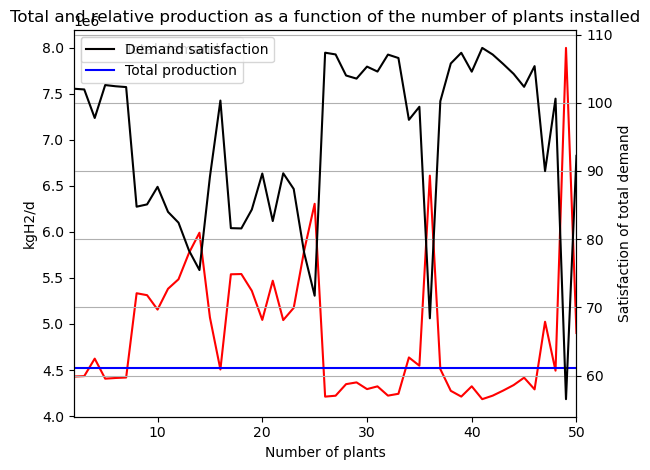

In [24]:
totalDemand = []
totProduction = []

for servs in plantsServings:
    totalDemand.append(0)
    
    for serv in servs:
        totalDemand[-1] += sum([pipesDestination.loc[a, "h2Need"] for a in serv])

for prods in plantsSpecifications:
    totProduction.append(sum([a for a in prods]))

fig, ax1 = plt.subplots()

ax1.plot(X, totalDemand, color = "r", label = "Total demand")
ax1.plot(X, totProduction, color = "b", label = "Total production")

ax1.set_title("Total and relative production as a function of the number of plants installed")
ax1.set_xlabel('Number of plants')
ax1.set_ylabel('kgH2/d')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

ax2.plot(X, 100 * np.divide(np.array(totProduction), np.array(totalDemand)), color="k", label = "Demand satisfaction")

ax2.set_ylabel('Satisfaction of total demand', color="k")  # we already handled the x-label with ax1

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xlim([min(X), max(X)])

plt.grid()
ax1.legend()
ax2.legend()

plt.show()

In [13]:
def find_pareto_frontier(input):
    out = []
    data = np.unique(input, axis=0)

    for i in range(data.shape[0]):
        c_data = np.tile(data[i, :], (data.shape[0], 1))
        t_data = data.copy()
        t_data[i, :] = np.inf
        smaller_idx = c_data >= t_data

        idx = np.sum(smaller_idx, axis=1) == data.shape[1]
        if not np.any(idx):
            out.append(data[i, :])

    membership = np.all(np.any(input[:, None, :] == np.array(out)[None, :, :], axis=2), axis=1)
    member_value = np.array(out)

    return membership, member_value

# Define the power-law function
def power_law(x, a, b, c):
    return a + (b * x**c)

In [14]:
with open("project_data/out/pareto_10.json", 'r') as file:
    paretoValues = json.load(file)

In [25]:
x = np.array([paretoValues["meanLengths"], paretoValues["prices"]]).T
membership, member_value = find_pareto_frontier(x)

# Take the pareto points
x_pareto = member_value[:, 0]
y_pareto = member_value[:, 1]

# Fit the data to the power-law model
params, covariance = curve_fit(power_law, x_pareto, y_pareto, maxfev=10*len(x[:, 1]))
a, b, c = params

# Make the fitted curve
x_fit = np.linspace(min(x[:, 0]), max(x[:, 0]), 100)
y_fit = power_law(x_fit, a, b, c)

# Plot the results
plt.plot(x_fit, y_fit, label=f"Fitted Curve: y = {a:.2f} + {b:.2f} * x^{c:.2f}", color='red')
plt.scatter(x[:, 0], x[:, 1], c='b')
plt.scatter(x_pareto, y_pareto, label='Pareto Points', c = 'g')

plt.title("Pareto front")
plt.xlabel("Mean length [km]")
plt.ylabel("Total CAPEX [m$]")

plt.grid()
plt.legend()

plt.show()

NameError: name 'paretoValues' is not defined

# Plot the results

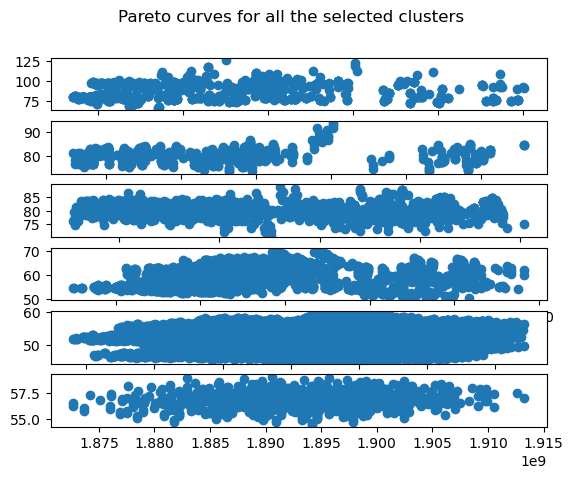

In [23]:
paretoClusters = [5, 10, 15, 25, 35, 50]

fig, axs = plt.subplots(len(paretoClusters))
fig.suptitle('Pareto curves for all the selected clusters')

for i, n in enumerate(paretoClusters):
    temp = {}
    with open("project_data/out/pareto_" + str(n) + ".json", 'r') as file:
        temp = json.load(file)
    
    axs[i].scatter(temp["prices"], temp["meanLengths"])

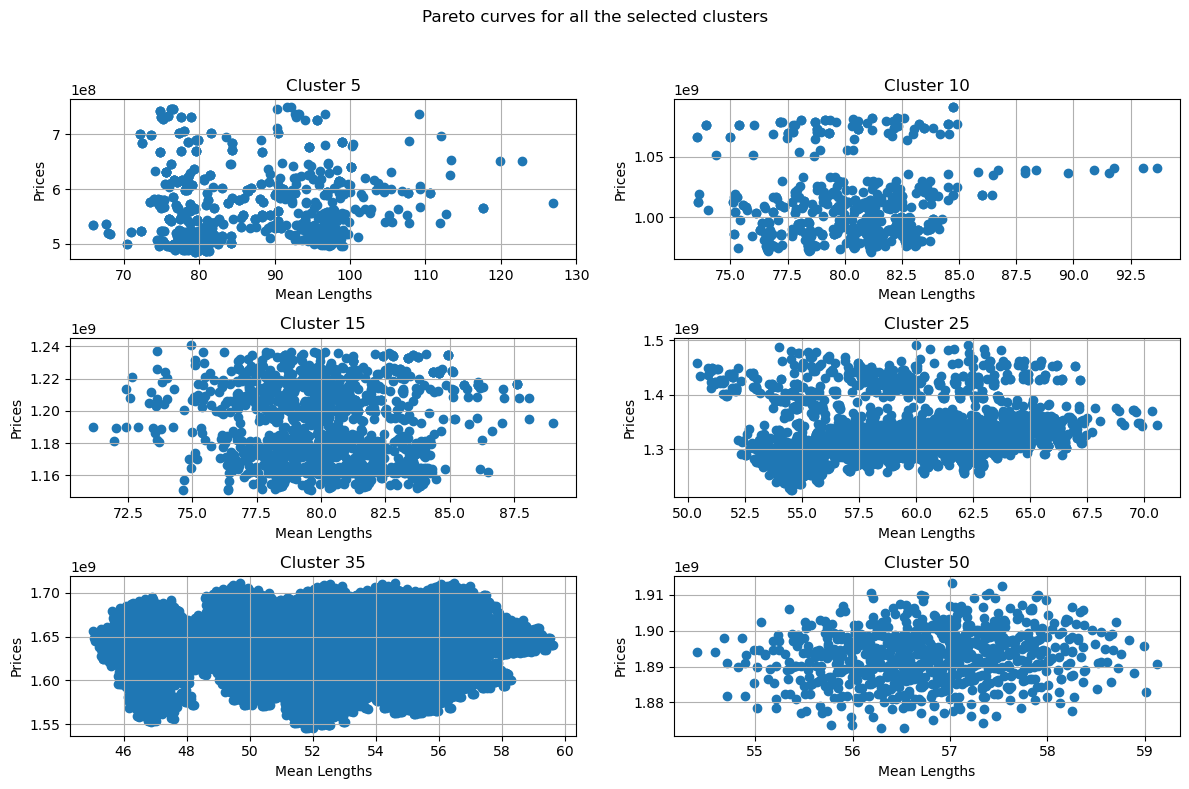

In [27]:
paretoClusters = [5, 10, 15, 25, 35, 50]

# Create subplots with 2 columns
num_rows = (len(paretoClusters) + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 8))
fig.suptitle('Pareto curves for all the selected clusters')

# Flatten axs if necessary
if num_rows > 1:
    axs = axs.flatten()

# Add titles, x-axis label, and y-axis label to each subplot
for i, n in enumerate(paretoClusters):
    temp = {}
    with open("project_data/out/pareto_" + str(n) + ".json", 'r') as file:
        temp = json.load(file)
    
    row = i // 2
    col = i % 2
    
    axs[i].scatter(temp["meanLengths"], temp["prices"])
    axs[i].set_title(f'Cluster {n}')
    axs[i].set_xlabel('Mean Lengths')
    axs[i].set_ylabel('Prices')
    
    # Add a grid
    axs[i].grid(True)

# Hide any empty subplots
if len(paretoClusters) % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()